In [ ]:
# Reload and core imports
%reload_ext autoreload
%autoreload 2

# All-in-one imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from dolfin import *
from dolfin import Constant, Function, TestFunction, TrialFunction, VectorFunctionSpace, FunctionSpace, DirichletBC, Measure, assemble, dx, ds, inner, grad, div, sym, nabla_grad, sqrt, dot, outer, split, assign, interpolate
#from dolfin_adjoint import *
#from src.Optimiser import objective_function#, #spacing_constraint

#import objective_function, solve_tidal_flow_velocities_fast, update_turbine_field, setup_tidal_solver

from Dolfin_optimisation.src.solver import solve_tidal_flow_velocities2

#from Dolfin_optimisation.src.turbines import (
     #compute_turbine_power, #summarize_turbine_power, 
    #plot_turbine_layout
#)

from Dolfin_optimisation.src.plots import plot_velocity_field, compute_power_field_plot, compare_layouts

from scipy.optimize import minimize, differential_evolution
from ufl import dot, div, grad, sqrt, nabla_grad, inner, outer, sym, measure
#from dolfin_adjoint import *

from petsc4py import PETSc

print("✅ Thesis SWE solver ready (v21-01)")

✅ Thesis SWE solver ready (v21-01)


In [ ]:
# --- Physical and turbine parameters ---

rho = 1025.0         # Water density [kg/m³]
g = 9.81             # Gravitational acceleration [m/s²]
depth = 50.0         # Water depth [m]
nu = Constant(1.0)  # Effective viscosity [m²/s]

C_T = 0.7             # Turbine thrust coefficient [-]
C_D = 0.0025          # Drag coefficient [-]
D = 10               # Turbine diameter
sigma = 0.5*D         # Wake Gaussian spread [m]

A_T = np.pi*D**2            # Turbine swept area [m²]

# --- Flow properties ---
U_inflow = 2.0       # Inflow velocity [m/s]

#cb = 0.0025    # Bed friction coefficient [-]
#viscosity = 3 #for now keep turbulent visc or eddy visc

#H = depth  # total depth (assuming flat bottom for now)
#nu = nu_eff  # viscosity coefficient
# --- Initial conditions ---
initial_condition_u = Constant((2.0, 0.0))
initial_condition_eta = Constant(0.0) # Start with no surface elevation

#----Mesh parameters----
Lx, Ly = 400.0, 400.0
Nx, Ny = 40, 40

n_turbines = 10            # number of turbines
min_spacing = 2*D     # minimum spacing between turbines [m]

# --- Plot toggles ---
show_mesh_plot = False # toggle to plot the mesh
show_plot_turbines = False # toggle to show turbine layout plot
show_turbines_coordinates = True # toggle to show turbine coordinates


#distance from boundaries
distance_from_inlet = 10*D
distance_to_side = 10*D
distance_to_outlet = 10*D

#no slip or free slip if noslip = false -> free slip
noslip = False


print(f"Initialized base parameters successfully.")

Initialized base parameters successfully.


In [91]:
def setup_swe_problem(Lx, Ly, Nx, Ny, U_inflow, showplot):
    # --- Domain and mesh setup ---
    mesh = RectangleMesh(Point(0.0, 0.0), Point(Lx, Ly), Nx, Ny)

    # --- Mixed Taylor–Hood function space ---
    P2 = VectorElement("P", mesh.ufl_cell(), 2)   # Quadratic velocity
    P1 = FiniteElement("P", mesh.ufl_cell(), 1)   # Linear free-surface
    mixed_element = MixedElement([P2, P1])
    W = FunctionSpace(mesh, mixed_element)

    # --- Define trial functions and test functions ---
    w = Function(W)           # Combined [u, eta]
    u, eta = split(w)
    v, q = TestFunctions(W)
    
    # --- Initialize uniform inflow velocity ---
    V_sub = W.sub(0).collapse()
    u_init = interpolate(Constant((2, 0.0)), V_sub)
    assign(w.sub(0), u_init)

    # --- Mesh visualization (optional) ---
    print(f"Success! Initialized u_init with U_inflow = {U_inflow} m/s "
          f"on a {Nx}x{Ny} mesh.")

    if not showplot:
        return mesh, W, w, u, eta, v, q
        
    plt.figure(figsize=(6, 5))
    plot(mesh)
    plt.title("Computational mesh verification")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.tight_layout()
    plt.show()

    return mesh, W, w, u, eta, v, q

def place_turbines_random2(Lx, Ly, n_turbines, sigma, min_spacing, distance_from_inlet, distance_to_side, distance_to_outlet, max_attempts=10000):
     # Enforce placement rectangle
    xmin = distance_from_inlet 
    xmax = Lx - distance_to_outlet 
    ymin = distance_to_side 
    ymax = Ly - distance_to_side 

    if xmax <= xmin or ymax <= ymin:
        raise ValueError("Domain too small for requested placement bounds and margin")

    positions = []
    attempts = 0

    while len(positions) < n_turbines and attempts < max_attempts:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        new_pos = np.array([x, y])

        if all(np.linalg.norm(new_pos - np.array(pos)) >= min_spacing for pos in positions):
            positions.append(new_pos)

        attempts += 1
    print(f"Managed to place {len(positions)} turbines within {attempts} attempts.")

    if len(positions) < n_turbines:
        raise RuntimeError("Failed to place all turbines with the given constraints.")
    else:
        print("Turbines placed successfully.")

    return np.array(positions)

def set_up_bcs_and_markers3(Lx, Ly, mesh, W, U_inflow, noslip):
    class InletBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0.0)

    class OutflowBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], Lx)

    class WallBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and (near(x[1], 0.0) or near(x[1], Ly))

    # --- Create and mark boundary facets ---
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
    inlet  = InletBoundary();  inlet.mark(boundary_markers, 1)
    outlet = OutflowBoundary(); outlet.mark(boundary_markers, 2)
    walls  = WallBoundary();   walls.mark(boundary_markers, 3)

    inflow_expr = Constant((U_inflow, 0.0))
    bc_inflow = DirichletBC(W.sub(0), inflow_expr, boundary_markers, 1)
    print(f"Boundary markers created and BCs applied:")
    print(f"   - Inlet  (ID=1): inflow velocity = {U_inflow:.2f} m/s")
    print( "   - Outlet (ID=2): open boundary (no Dirichlet BC)")

    if noslip:
        noslip  = dlf.Constant((0.0, 0.0))
        bc_wall = dlf.DirichletBC(W.sub(0), noslip, boundary_markers, 3)
        bcs = [bc_inflow, bc_wall]
        print( "   - Walls  (ID=3): no‑slip (Dirichlet BC)\n")

    else:
        bcs = [bc_inflow]
        print( "   - Walls  (ID=3): free‑slip (no Dirichlet BC)\n")

    return boundary_markers, bcs

def show_turbine_positions(initial_positions, showcoordinates):
    
    if showcoordinates:
        print("The initial turbine positions are:")
        for i, pos in enumerate(initial_positions):
            print(f" Turbine {i+1}: x = {pos[0]:.2f} m, y = {pos[1]:.2f} m")
    else:
        print("Turbine coordinates display not requested.")
    return

def plot_turbine_layout2(mesh, turbine_positions, Lx, Ly, sigma, showplot):
    if not showplot:
        return 
    plt.figure(figsize=(7, 5))
    fe_plot(mesh, linewidth=0.2, color="lightgray")

    for (x_i, y_i) in turbine_positions:
        plt.plot(x_i, y_i, 'ro', markersize=6)
        circle = plt.Circle(
            (x_i, y_i), 2*sigma,
            color='r', fill=False, linestyle='--', linewidth=1
        )
        plt.gca().add_artist(circle)

    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title(f"Random placement of {len(turbine_positions)} turbines")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [92]:
#setting up mesh and initial turbine positions and boundary conditions and markers
mesh, W, w, u, eta, v, q = setup_swe_problem(
    Lx, Ly, Nx, Ny, U_inflow, show_mesh_plot
)

turbine_positions = place_turbines_random2(Lx, Ly, n_turbines, sigma, min_spacing, distance_from_inlet, distance_to_side, distance_to_outlet)

show_turbine_positions(turbine_positions, show_turbines_coordinates)
plot_turbine_layout2(mesh, turbine_positions, Lx, Ly, sigma, show_plot_turbines)

boundary_markers, bcs = set_up_bcs_and_markers3(Lx, Ly, mesh, W, U_inflow, noslip)





Success! Initialized u_init with U_inflow = 2.0 m/s on a 40x40 mesh.
Managed to place 10 turbines within 12 attempts.
Turbines placed successfully.
The initial turbine positions are:
 Turbine 1: x = 201.54 m, y = 182.30 m
 Turbine 2: x = 147.90 m, y = 212.69 m
 Turbine 3: x = 219.79 m, y = 198.89 m
 Turbine 4: x = 180.89 m, y = 236.32 m
 Turbine 5: x = 298.10 m, y = 178.17 m
 Turbine 6: x = 125.72 m, y = 122.20 m
 Turbine 7: x = 247.00 m, y = 194.98 m
 Turbine 8: x = 287.49 m, y = 101.36 m
 Turbine 9: x = 148.73 m, y = 115.63 m
 Turbine 10: x = 206.74 m, y = 295.92 m
Boundary markers created and BCs applied:
   - Inlet  (ID=1): inflow velocity = 2.00 m/s
   - Outlet (ID=2): open boundary (no Dirichlet BC)
   - Walls  (ID=3): free‑slip (no Dirichlet BC)



No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.404e+00 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 6.165e-01 (tol = 1.000e-08) r (rel) = 7.336e-02 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 5.818e-03 (tol = 1.000e-08) r (rel) = 6.923e-04 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 1.133e-06 (tol = 1.000e-08) r (rel) = 1.348e-07 (tol = 1.000e-07)
  Newton iteration 4: r (abs) = 1.501e-12 (tol = 1.000e-08) r (rel) = 1.785e-13 (tol = 1.000e-07)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
The total power is 6442.8 kW


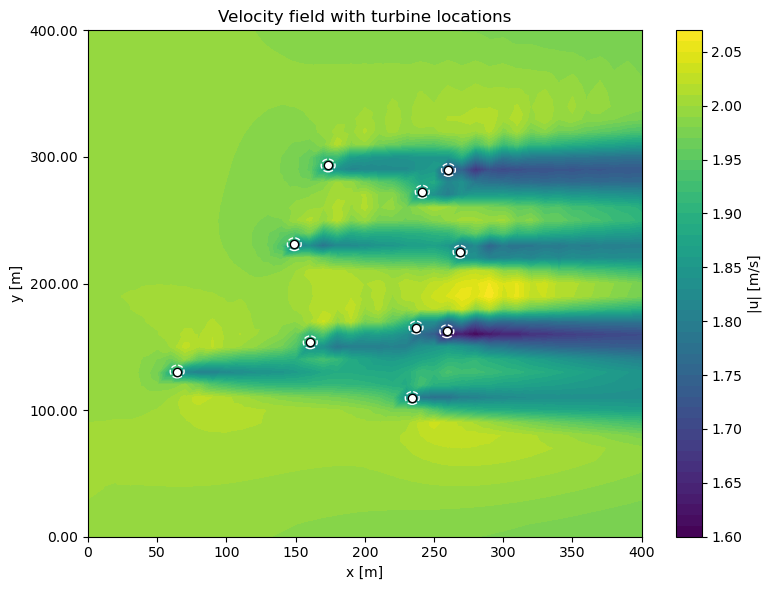

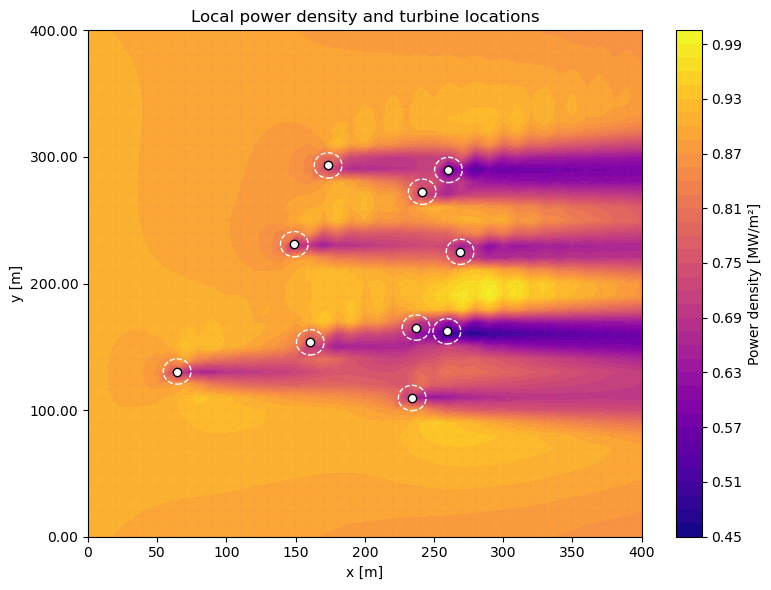

In [74]:
init_total_power, init_velocity = solve_tidal_flow_velocities2(
    turbine_positions,
    w,
    W,
    mesh,
    bcs,
    rho,
    depth,
    nu,
    C_D,
    g,
    C_T,
    A_T,
    sigma,
)

plot_velocity_field(w, turbine_positions, sigma, Lx, Ly)
compute_power_field_plot(C_T, rho, A_T, w, turbine_positions, sigma, Lx, Ly)

In [20]:
#  SETUP
solver_ctx = setup_tidal_solver(mesh, W, depth, nu, cb, g)
print("Solver context built, Zoë.")

bounds = [(0, Lx), (0, Ly)] * n_turbines

# Prepare unified objective wrapper
def objective_wrapper(x):
    return objective_function(x, solver_ctx, mesh, bcs, rho, C_T, A_T, sigma, D)

# Optional: small randomised initial population (diversify search)
init_population = np.vstack([
    x0,
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines)
])

# ------------------------------------------------------------
#  GLOBAL OPTIMISATION (Differential Evolution)
# ------------------------------------------------------------
print("\n Starting global differential evolution search.")

global_result = differential_evolution(
    func=objective_wrapper,     # call wrapper (no explicit args)
    bounds=bounds,
    init=init_population,       # start near current layout
    maxiter=2,                 # broad exploration
    popsize=5,
    mutation=(0.7, 1.2),
    recombination=0.8,
    updating='immediate',
    workers=1,                  # FEniCS and multiprocessing don't mix
    disp=False,
    polish=False                # we'll polish ourselves
)

print(f"\n Global search complete.")
print(f"   Best preliminary objective (negative power): {global_result.fun:.3e}")

# ------------------------------------------------------------
#  LOCAL OPTIMISATION (L‑BFGS‑B refinement)
# ------------------------------------------------------------
print("\n Refining solution locally with L‑BFGS‑B ...")

res_local = minimize(
    objective_wrapper,
    x0=global_result.x,         # start from DE best layout
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 2, 'disp': False}
)

# ------------------------------------------------------------
#  CHOOSE FINAL RESULT
# ------------------------------------------------------------
if res_local.fun < global_result.fun:
    best_result = res_local
    source = "Local (refined)"
else:
    best_result = global_result
    source = "Global (no improvement)"

opt_positions = best_result.x.reshape(-1, 2)
print(f"\n Hybrid optimisation complete — using {source} result.")
print(f" Final objective (negative power): {best_result.fun:.3e}")

best_power_global = -global_result.fun
best_power_local = -res_local.fun
print(f"Best power after global search: {best_power_global/1e3:.2f} kW")
print(f"Best power after local refinement: {best_power_local/1e3:.2f} kW")



Solver context built, Zoë.

 Starting global differential evolution search.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Initial guess reset to inflow velocity field.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.673e+03 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 8.020e+02 (tol = 1.000e-08) r (rel) = 3.001e-01 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 2.406e+02 (tol = 1.000e-08) r (rel) = 9.003e-02 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 7.219e+01 (tol = 1.000e-08) r (rel) = 2.701e-02 (tol = 1.000e-07)
  Newton iteration 4: r (abs) = 2.166e+01 (tol = 1.000e-08) r (rel) = 8.103e-03 (tol = 1.000e-07)
  Newton iteration 5: r (abs) = 6.497e+00 (tol = 1.000e-08) r (rel) = 2.431e-03 (tol = 1.000e-07)
  Newton iteration 6: r (abs) = 1.949e+00 (tol = 1.000e-08) r (rel) = 7.293e-04 (tol = 1.000e-07)
  Newton iteration 7: r (abs) = 5.847e-01 (tol = 1.000e-08) r (rel) = 2.188e-04 (tol = 

ModuleNotFoundError: No module named 'src'

In [ ]:
# --- Compute power and velocity for optimal layout ---

opt_total_power, opt_velocity = solve_tidal_flow_velocities(
    opt_positions,
    w, W, mesh, bcs,
    rho, depth, nu, cb, g,
    C_T, A_T, sigma,
)

# --- Compute per-turbine data for optimal layout ---
opt_turbine_powers, opt_turbine_velocities = compute_turbine_power(
    opt_velocity, opt_positions, rho, C_T, A_T
)

# --- Summarise results ---
opt_total_power_check, opt_max_park_power, _, _ = summarize_turbine_power(
    opt_turbine_powers, opt_turbine_velocities,
    rho, C_T, A_T, U_inflow, n_turbines
)

# --- Compute relative improvement and efficiency ---
improvement_pct = (opt_total_power_check - init_total_power) / init_total_power * 100
efficiency_pct = opt_total_power_check / opt_max_park_power * 100

# --- Print clean summary ---
print("\n========  LAYOUT OPTIMISATION SUMMARY  ========")
print(f"{'Initial total power:':35s} {init_total_power/1e3:10.2f} kW")
print(f"{'Optimised total power:':35s} {opt_total_power_check/1e3:10.2f} kW")
print(f"{'Maximum theoretical power (no wake):':35s} {opt_max_park_power/1e6:10.2f} MW")
print(f"{'Relative improvement:':35s} {improvement_pct:10.2f} %")
print(f"{'Farm efficiency:':35s} {efficiency_pct:10.2f} %")
print("===============================================\n")

# --- Combined layout comparison ---
compare_layouts(mesh, Lx, Ly, turbine_positions, opt_positions, sigma)

# --- Velocity and power field plots for optimal layout ---
plot_velocity_field(w, opt_positions, sigma, Lx, Ly)
compute_power_field_plot(C_T, rho, A_T, w, opt_positions, sigma, Lx, Ly)


NameError: name 'solve_tidal_flow_velocities' is not defined

In [ ]:
try:
    import dolfin_adjoint
    print("✅ dolfin_adjoint is installed.")
except ImportError:
    print("❌ dolfin_adjoint not found.")

try:
    import pyadjoint
    print("✅ pyadjoint is installed.")
except ImportError:
    print("❌ pyadjoint not found.")

import dolfin, dolfin_adjoint
print(dolfin.__file__)
print(dolfin_adjoint.__file__)


/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ dolfin_adjoint is installed.
✅ pyadjoint is installed.
/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/dolfin/__init__.py
/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/dolfin_adjoint/__init__.py
